# Training and forecast example of an automated ARIMA model (TBATS).

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from fbprophet import Prophet
from tbats import TBATS

## Load dataset

In [3]:
ts60 = pd.read_csv('../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
load60.head()

datetime
2020-11-06 00:00:00    2.60
2020-11-06 01:00:00    2.61
2020-11-06 02:00:00    2.57
2020-11-06 03:00:00    2.58
2020-11-06 04:00:00    2.60
Name: Diff Load Activa Total (60 minuto), dtype: float64

## Seasonality detection
The time series is highly seasonal so this requires some further inspection.

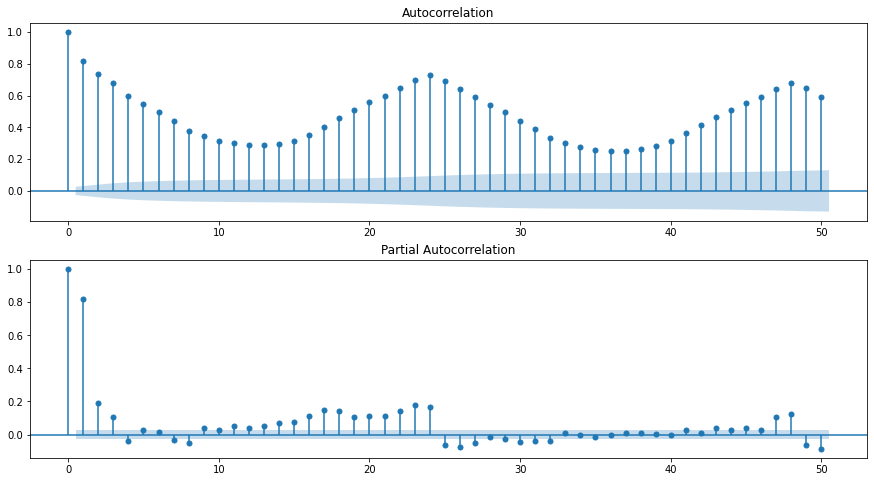

In [4]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(load60, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(load60, lags=50, ax=ax[1])
plt.show()

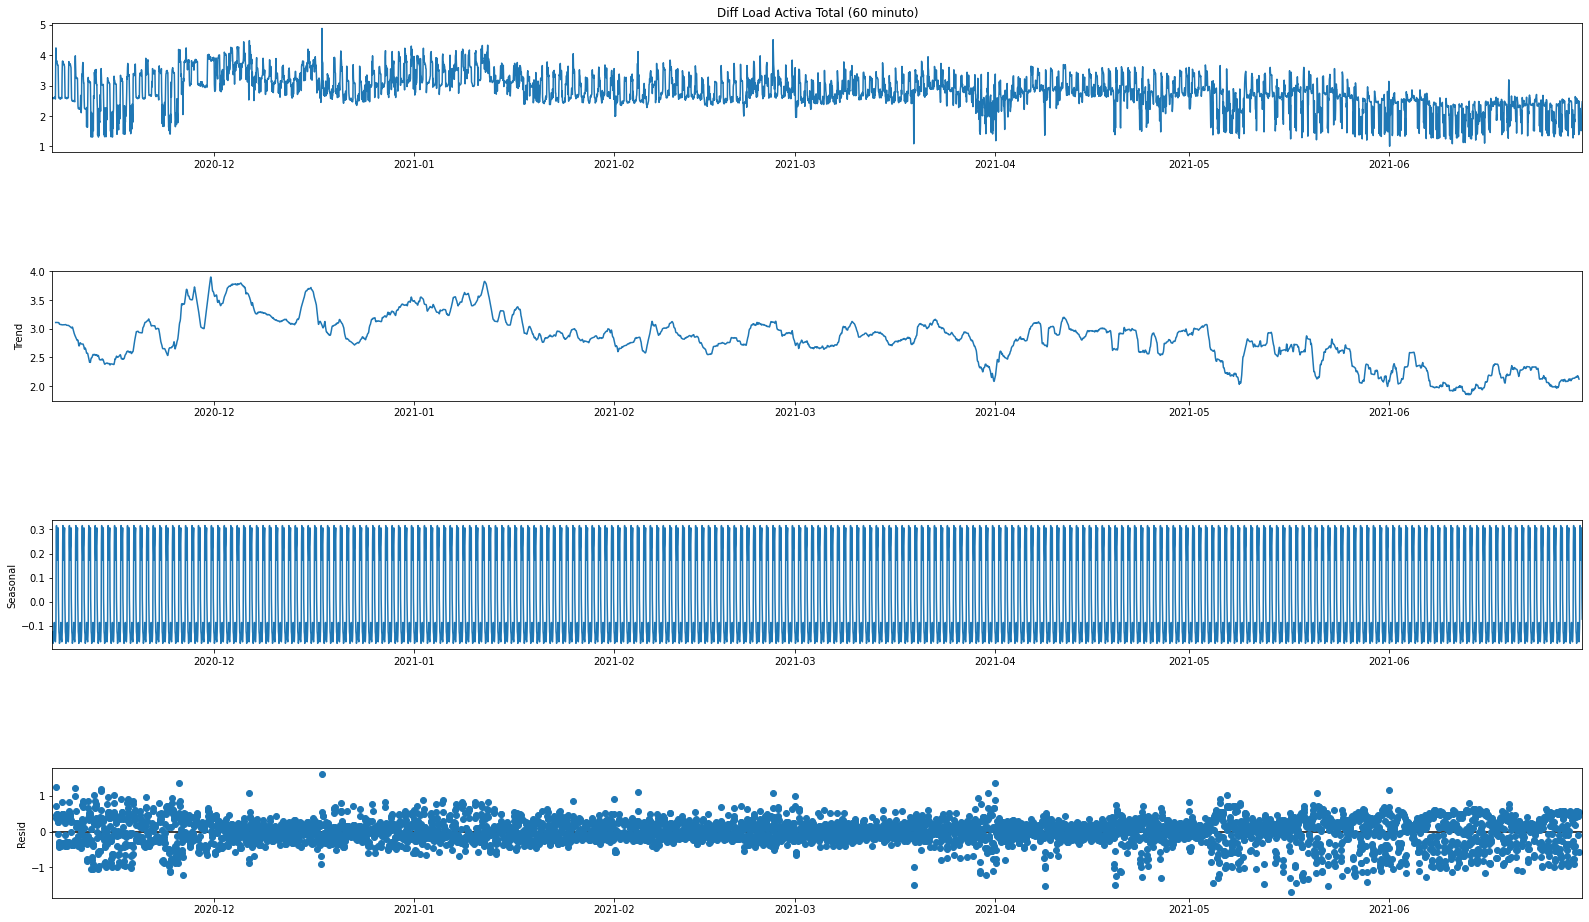

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(load60,  model='additive', period=24)
f = result.plot()
f.set_figheight(15)
f.set_figwidth(25)
plt.show()

Daily seasonality is obvious from all above plots. e.g. ACF is repeated every 24 timesteps. Therefore seasonal models are expected to produce better results.

## Configuration

Steps for day ahead forecasts are preset to 24 (1 day). days_ahead are the number of days to reproduce forecast without retraining.

In [6]:
steps = 24
days_ahead = 11

## Train / test split

In [7]:
last_train_day = datetime(2021, 6, 20)
train = load60[:(last_train_day - timedelta(hours=1))]
train = train.asfreq('H')
test = load60[last_train_day:last_train_day + timedelta(hours=days_ahead*steps-1)]
test = test.asfreq('H')


## Training TBATS
In this section 2 TBATS models are fitted.

### Fit TBATS simple

In [8]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6)
model = estimator.fit(train)
model.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [6 3]\nARMA errors (p, q): (2, 3)\nSmoothing (Alpha): 0.714396\nTrend (Beta): -0.162353\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-1.07902252e-06  4.34763518e-06  7.43490665e-06  3.88911035e-06]\nAR coefficients [7.43490665e-06 3.88911035e-06]\nMA coefficients [-0.04648268 -0.03097639  0.07766102]\nSeed vector [ 2.07006131e+00  1.84772363e-01 -2.11118986e-02 -9.35068754e-02\n  8.17535871e-04 -6.05232690e-02  2.56109699e-02 -3.53025274e-03\n -2.37055358e-01  5.47179201e-03 -4.58840715e-02  3.31917920e-02\n  3.40086504e-02 -1.10634487e-02  4.94109814e-02  3.33252693e-03\n  1.09584162e-02  3.92189149e-02  3.98401070e-03 -2.85690387e-03\n  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00\n  0.00000000e+00]\n\nAIC 33568.686597'

#### Save model locally

In [9]:
fname = "../VEOLIA/models/tal_tbats_simple.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model, file)

### Fit TBATS complex

In [10]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6, use_box_cox=True, use_arma_errors=True, use_damped_trend=True, use_trend=True)
model_complex = estimator.fit(train)
model_complex.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: True\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [6 3]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 1.000000\nSmoothing (Alpha): 0.651829\nTrend (Beta): -0.145757\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-2.65708626e-07  1.66641202e-06 -1.75277561e-06  2.18477558e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 1.07006132e+00  1.84772357e-01 -2.11118972e-02 -9.35068723e-02\n  8.17535885e-04 -6.05232669e-02  2.56109690e-02 -3.53025269e-03\n -2.37055349e-01  5.47179158e-03 -4.58840702e-02  3.31917910e-02\n  3.40086493e-02 -1.10634484e-02  4.94109798e-02  3.33252672e-03\n  1.09584159e-02  3.92189136e-02  3.98401051e-03 -2.85690371e-03]\n\nAIC 33589.164284'

### Save model locally

In [11]:
fname = "../VEOLIA/models/tal_tbats_complex.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model_complex, file)

## Day ahead forecasts

In [12]:
forecast = model.forecast(steps=steps)
forecast_complex = model_complex.forecast(steps=steps)

### Evaluation

In [18]:
print("Simple model:")
print("MAPE:", mape(test[:steps], forecast[:steps]))
print("MSE:", mse(test[:steps], forecast[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast[:steps])))

print("Complex model:")
print("MAPE:", mape(test[:steps], forecast_complex[:steps]))
print("MSE:", mse(test[:steps], forecast_complex[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast_complex[:steps])))

Simple model:
MAPE: 0.17261020917760775
MSE: 0.1761626310460319
RMSE: 0.41971732278526686
Complex model:
MAPE: 0.17363935207925288
MSE: 0.17721309014885844
RMSE: 0.4209668516033756


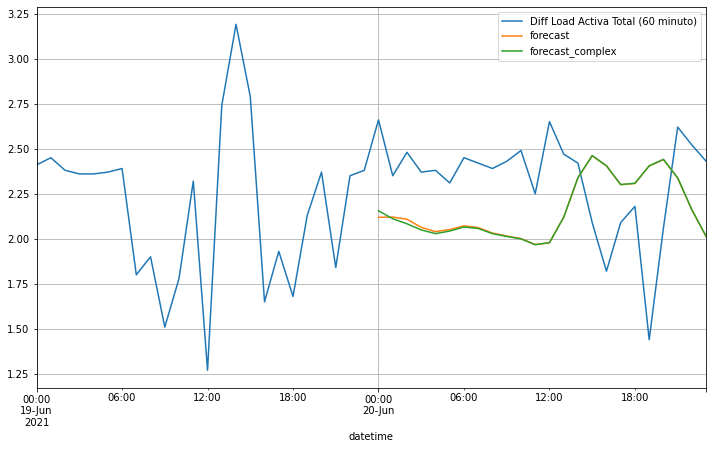

In [19]:
comparison = pd.DataFrame(test[:steps])
comparison['forecast'] = forecast
comparison['forecast_complex'] = forecast_complex
train = pd.DataFrame(train, columns=comparison.filter(like='Diff').columns.tolist())
comparison = pd.concat([train, comparison])
plt = comparison[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

## Training prophet
In this section facebook prophet is trained (supposed to capture seasonality).

In [20]:
# add datetime as column for prophet
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.values
# define the model
model_prophet = Prophet()
# fit the model
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -49.5367


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10484.9     0.0273445       409.801           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10505.9    0.00287892       93.3179           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10515.2     0.0004056       75.8513      0.7187      0.7187      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       10519.9   0.000214968         155.8   4.446e-07       0.001      472  LS failed, Hessian reset 
     399       10522.4    0.00180902       336.521           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10524.3     0.0240117       123.765           1           1      6

### Save model locally

In [21]:
fname = "../VEOLIA/models/tal_prophet.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model_prophet, file)

### Day-ahead forecast
A day-ahead forecast is produced and evaluated.

MAPE: 0.20328351306876172
MSE: 0.25089682032405425
RMSE: 0.5008960174767356


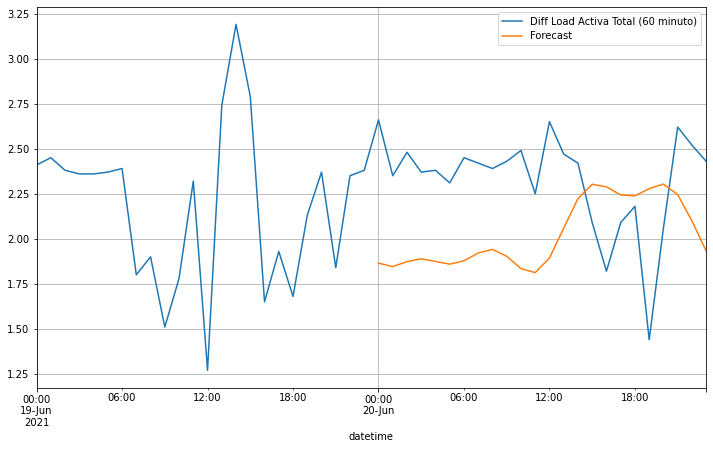

In [22]:
# evaluation
future = pd.DataFrame(test.index[:steps]).rename(columns={'datetime':'ds'})
forecast_prophet = model_prophet.predict(future)
predictions = forecast_prophet['yhat'].values
ground_truth = test[:steps]

print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

# plot forecast
comparison_prophet = pd.DataFrame(ground_truth)
comparison_prophet['Forecast'] = predictions
train = pd.DataFrame(train, columns=comparison_prophet.filter(like='Diff').columns.tolist())
comparison_prophet = pd.concat([train, comparison_prophet])
plt = comparison_prophet[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

Prophet is outperformed by TBATS but still results are not satisfying. Therefore we proceed to SARIMA models as described in the R_tal_time_series_analysis.

## Training SARIMA to capture seasonality

### SARIMA model from r gridsearch
A sarima is fitted as selected in the gridsearch process of R_tal_time_series_analysis.ipynb (further analysis can be sought there). However we have limited the seasonal autoregressive terms to 1 for speed and simplicity as longs as the model could not be saved otherwise. AIC, residuals, ACF, PACFs are presented again for completeness.

In [31]:
sarima = sm.tsa.statespace.SARIMAX(endog=train, order=(4, 1, 1),
                                   seasonal_order=(1, 1, 1, 24)).fit(max_iter=50, method='powell')
print(sarima.summary())

Optimization terminated successfully.
         Current function value: 0.146151
         Iterations: 10
         Function evaluations: 1013
                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -792.721
Date:                                Wed, 25 Aug 2021   AIC                           1601.442
Time:                                        16:14:13   BIC                           1654.194
Sample:                                    11-06-2020   HQIC                          1619.859
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

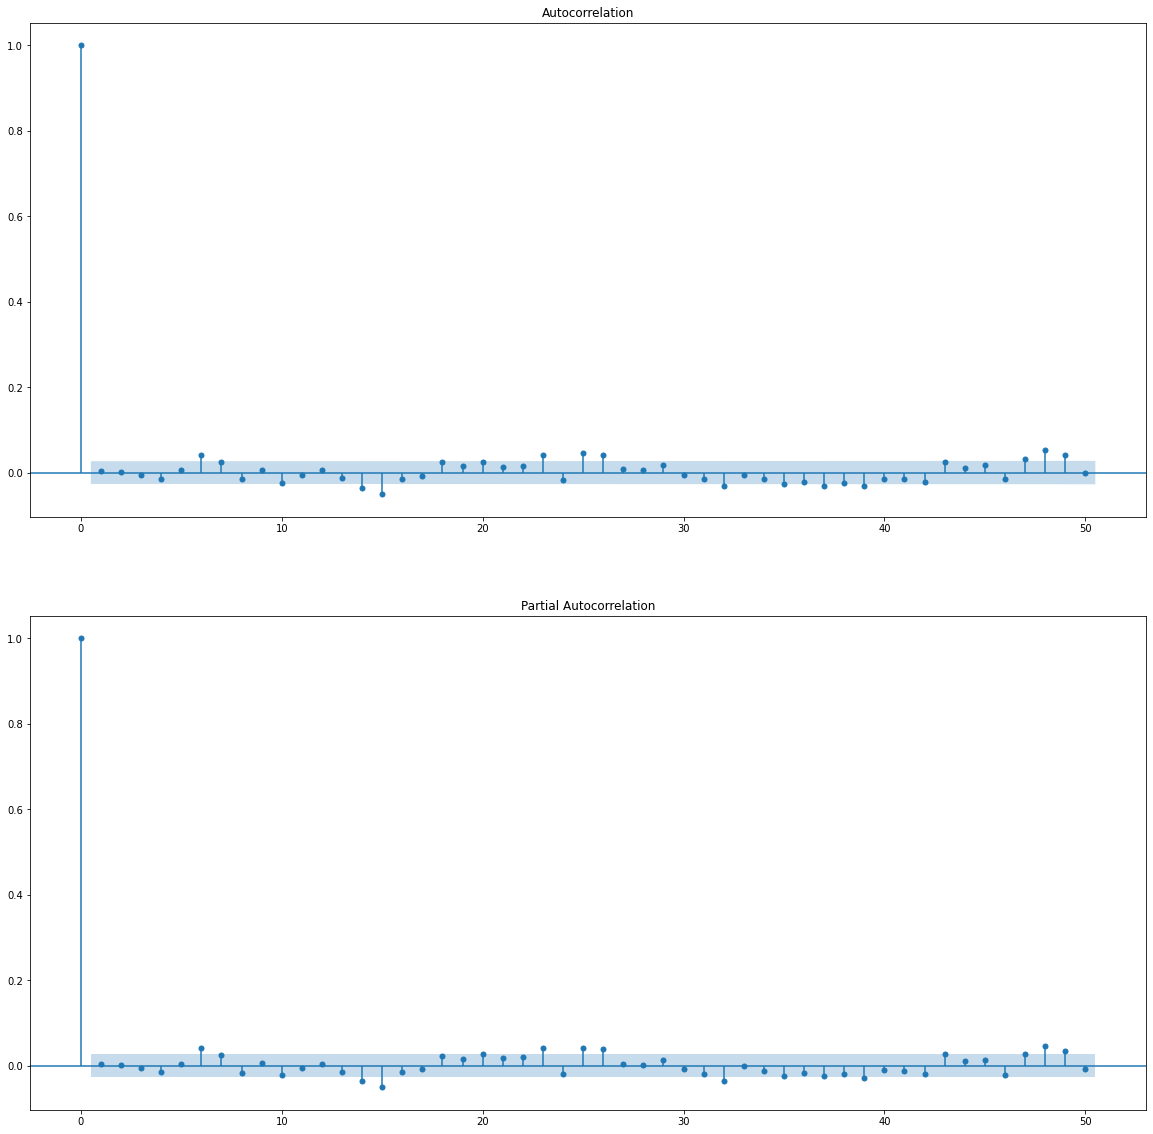

In [32]:
res = sarima.resid
fig, ax = plt.subplots(2,1, figsize=(20, 20))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

Ljung-Box seems pretty fine we do not reject the null hypothesis of non-correlated residuals. However, the Jarque-Bera test results to rejection of the null hypothesis that the residual distribution has no skewness and kurtosis. Normality condition is not met at all...

#### Save model locally

In [33]:
# workaround to make pickle work for SARIMAX
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

# storing
fname = "../VEOLIA/models/tal_sarima.pkl"  
file = open(fname, 'wb')
pickle.dump(sarima, file)
file.close()

### 11-day ahead forecast

In [34]:
print(f"Advanced {days_ahead} day ahead forecast:")
ground_truth_line = pd.concat([train[-5*24:], test])

predictions = pd.Series(dtype='float64')
for n_day in range(days_ahead):
    cur_timestep = n_day * steps
    next_timestep =  cur_timestep + steps
    day_preds = sarima.forecast(steps)
    predictions = pd.concat([predictions, day_preds])
    y_news = test.iloc[cur_timestep: next_timestep]
    y_news = y_news.asfreq('H')
    sarima = sarima.append(y_news)

predictions.name = test.name
predictions = predictions.rename_axis('datetime')

# Evaluation metrix
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

# Plot the last 5 days of data and the 11 days of forecast
plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

Advanced 11 day ahead forecast:


It is obvious that the model fails to capture the fluctuations of the inter-day variance of the load as all spikes (especially downward ones) cannot be forecasted effectively. This is due to the condition of constant variance in ARIMA models.

## SARIMAX for weather and time variables

In [25]:
weather = pd.read_csv('../VEOLIA/artifacts/weather_curated_60min.csv',
                      index_col=0, parse_dates=True)[datetime(2020, 11, 6):]
weather.head()

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
datetime,,,,,,,,,,,,,
2020-11-06 00:00:00,9.13,6.24,8.69,11.13,1021,92,5.7,70,0.0,0.0,0.0,97,500
2020-11-06 01:00:00,10.97,10.19,9.24,11.58,1020,79,7.2,130,0.0,0.0,0.0,75,803
2020-11-06 02:00:00,11.09,10.34,10.36,11.48,1020,80,7.7,140,0.0,0.2,0.0,0,500
2020-11-06 03:00:00,10.67,9.93,9.24,11.03,1020,82,6.2,140,0.0,0.0,0.0,0,800
2020-11-06 04:00:00,11.39,10.65,9.80,11.94,1019,79,6.2,130,0.0,0.0,0.0,0,800


In [26]:
time = pd.read_csv('../VEOLIA/artifacts/time_60min.csv',
                   index_col=1, parse_dates=True)[datetime(2020, 11, 6):]
time_useful = time[['weekday', 'weekend', 'holiday', 'hour']].astype(int)
time_useful.head()


,weekday,weekend,holiday,hour
datetime,,,,
2020-11-06 00:00:00,4,0,0,0
2020-11-06 01:00:00,4,0,0,1
2020-11-06 02:00:00,4,0,0,2
2020-11-06 03:00:00,4,0,0,3
2020-11-06 04:00:00,4,0,0,4


In [27]:
exog_training = pd.concat((weather.loc[train.index], time_useful.loc[train.index]), axis=1)
exog_testing = pd.concat((weather.loc[test.index], time_useful.loc[test.index]), axis=1)
exog_training.head()


,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id,weekday,weekend,holiday,hour
datetime,,,,,,,,,,,,,,,,,
2020-11-06 00:00:00,9.13,6.24,8.69,11.13,1021,92,5.7,70,0.0,0.0,0.0,97,500,4,0,0,0
2020-11-06 01:00:00,10.97,10.19,9.24,11.58,1020,79,7.2,130,0.0,0.0,0.0,75,803,4,0,0,1
2020-11-06 02:00:00,11.09,10.34,10.36,11.48,1020,80,7.7,140,0.0,0.2,0.0,0,500,4,0,0,2
2020-11-06 03:00:00,10.67,9.93,9.24,11.03,1020,82,6.2,140,0.0,0.0,0.0,0,800,4,0,0,3
2020-11-06 04:00:00,11.39,10.65,9.80,11.94,1019,79,6.2,130,0.0,0.0,0.0,0,800,4,0,0,4


In [28]:
sarimax = sm.tsa.statespace.SARIMAX(endog=train, order=(4, 1, 1), exog=exog_training.values,
                                   seasonal_order=(1, 1, 1, 24)).fit(max_iter=50, method='powell')
print(sarimax.summary())

Optimization terminated successfully.
         Current function value: 0.127840
         Iterations: 17
         Function evaluations: 4478
                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -693.402
Date:                                Wed, 25 Aug 2021   AIC                           1436.805
Time:                                        16:10:14   BIC                           1601.654
Sample:                                    11-06-2020   HQIC                          1494.358
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

#### Save model locally

In [29]:
# workaround to make pickle work for SARIMAX
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

# storing
fname = "../VEOLIA/models/tal_sarimax_plus_time_features.pkl"  
file = open(fname, 'wb')
pickle.dump(sarimax, file)
file.close()

### Simple 11-day ahead forecast + weather
Statsmodels does not provide news update with exogenous variables.

Simple 11 day ahead forecast:
MAPE naive: 0.12932806959843604
MAPE: 0.1140836051130656
MSE: 0.08299474832634199
RMSE: 0.28808809126088847


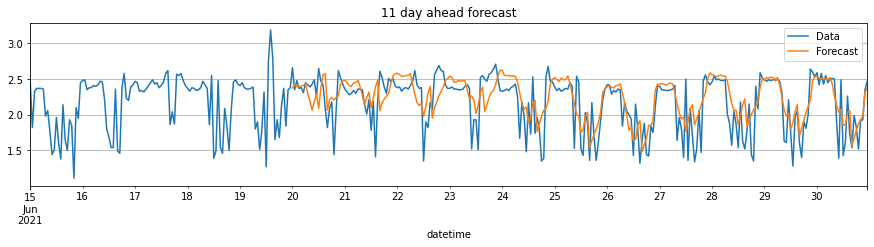

In [30]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarimax.forecast(steps * days_ahead, exog=exog_testing)
ground_truth_line = pd.concat([train[-int(days_ahead/2) * 24:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(
    15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()
